In [135]:
!pip install fredapi > /dev/null
!pip install plotly > /dev/null

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = 'your key'

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
fred_key = secrets.get_secret('fred-api')

# 1. Creating Fred object

In [137]:
fred =Fred(api_key=fred_key)

# 2. Using the Fred API to fetch data

In [138]:
sp_serach = fred.search('S&P', order_by='popularity')

In [139]:
sp_serach.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2023-11-22   2023-11-22   
CSUSHPINSA          CSUSHPINSA     2023-11-22   2023-11-22   
SP500                    SP500     2023-11-22   2023-11-22   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2023-11-22   2023-11-22   
MEHOINUSA672N    MEHOINUSA672N     2023-11-22   2023-11-22   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA        S&P/Case-Shiller U.S. National Home Price Index   
SP500                                                     S&P 500   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   
MEHOINUSA672N   Real Median Household Income in the United States   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2023-11-21  Daily, Close   
CSUSHPINSA            1987-01-01      2023-08-01       Monthly   
SP500                 2013-11-25      2023-11-22  Daily, Close   
BAMLH0A0HYM2EY        1996-12-31      2023-11-21  Daily, Close   
MEHOINUSA672N         1984-01-01      2022-01-01        Annual   

               frequency_short                           units  \
series id                                                        
BAMLH0A0HYM2                 D                         Percent   
CSUSHPINSA                   M              Index Jan 2000=100   
SP500                        D                           Index   
BAMLH0A0HYM2EY               D                         Percent   
MEHOINUSA672N                A  2022 CPI-U-RS Adjusted Dollars   

                             units_short      seasonal_adjustment  \
series id                                                           
BAMLH0A0HYM2                           %  Not Seasonally Adjusted   
CSUSHPINSA            Index Jan 2000=100  Not Seasonally Adjusted   
SP500                              Index  Not Seasonally Adjusted   
BAMLH0A0HYM2EY                         %  Not Seasonally Adjusted   
MEHOINUSA672N   2022 CPI-U-RS Adjusted $  Not Seasonally Adjusted   

               seasonal_adjustment_short               last_updated  \
series id                                                             
BAMLH0A0HYM2                         NSA  2023-11-22 08:43:02-06:00   
CSUSHPINSA                           NSA  2023-10-31 08:12:01-05:00   
SP500                                NSA  2023-11-22 19:10:59-06:00   
BAMLH0A0HYM2EY                       NSA  2023-11-22 08:43:08-06:00   
MEHOINUSA672N                        NSA  2023-09-12 13:48:02-05:00   

               popularity                                              notes  
series id                                                                     
BAMLH0A0HYM2           93  The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA             88  For more information regarding the index, plea...  
SP500                  83  The observations for the S&P 500 represent the...  
BAMLH0A0HYM2EY         83  This data represents the effective yield of th...  
MEHOINUSA672N          81  Household data are collected as of March.  As ...

# 3. Pulling data from Fred

<Axes: title={'center': 'S&P 500'}>

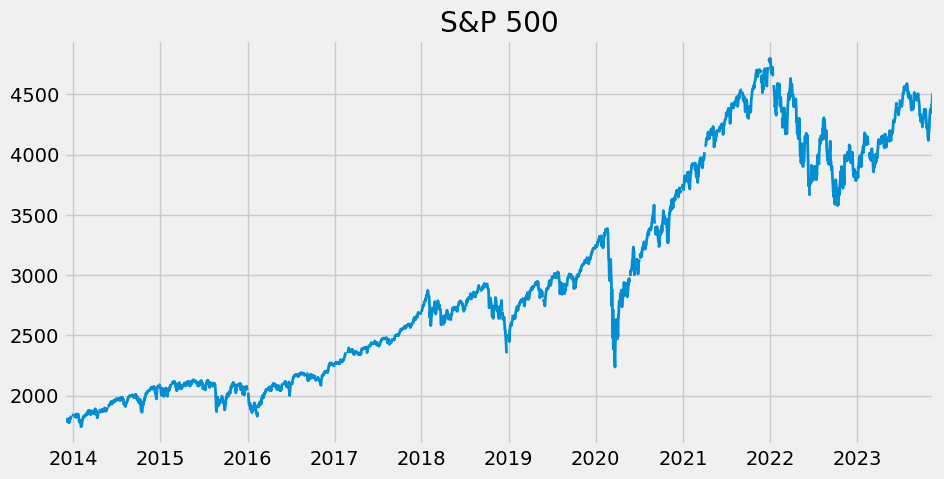

In [140]:
# Testing the pulling of data from fred
sp500 = fred.get_series('SP500')
sp500.plot(figsize=(10,5), title='S&P 500', lw=2)

# 4. Pull and join data from unemployment

In [141]:
#Search for unemployment data in fred
unem_result = fred.search('unemployment')

In [142]:
#Getting a series of data by the code name 'UNRATE'
unrate = fred.get_series('UNRATE')

In [143]:
#Filtering data we are interested of (monthly and frequency)
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))

In [144]:
#Further filtering and narrowing to more specific and clean data set
unemp_df = unemp_df.query('units == "Percent" and seasonal_adjustment == "Seasonally Adjusted" ')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [145]:
#Get the specific data series of unemploiment per each id in the 'unemp_df' data frame
# and save them in a list
all_results=[]

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemp_results = pd.concat(all_results, axis=1)

<Axes: >

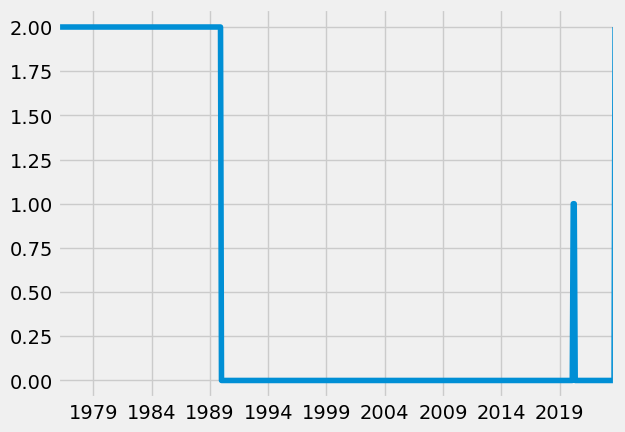

In [146]:
#Check how many null data we have
unemp_results.isnull().sum(axis=1).plot()

In [147]:
# Cleaning the null data
unem_states = unemp_results.dropna()
unem_states.shape

(403, 59)

In [148]:
#Interactive plot for the unemployment rates per state
px.line(unem_states)

## Analyzing a specific date

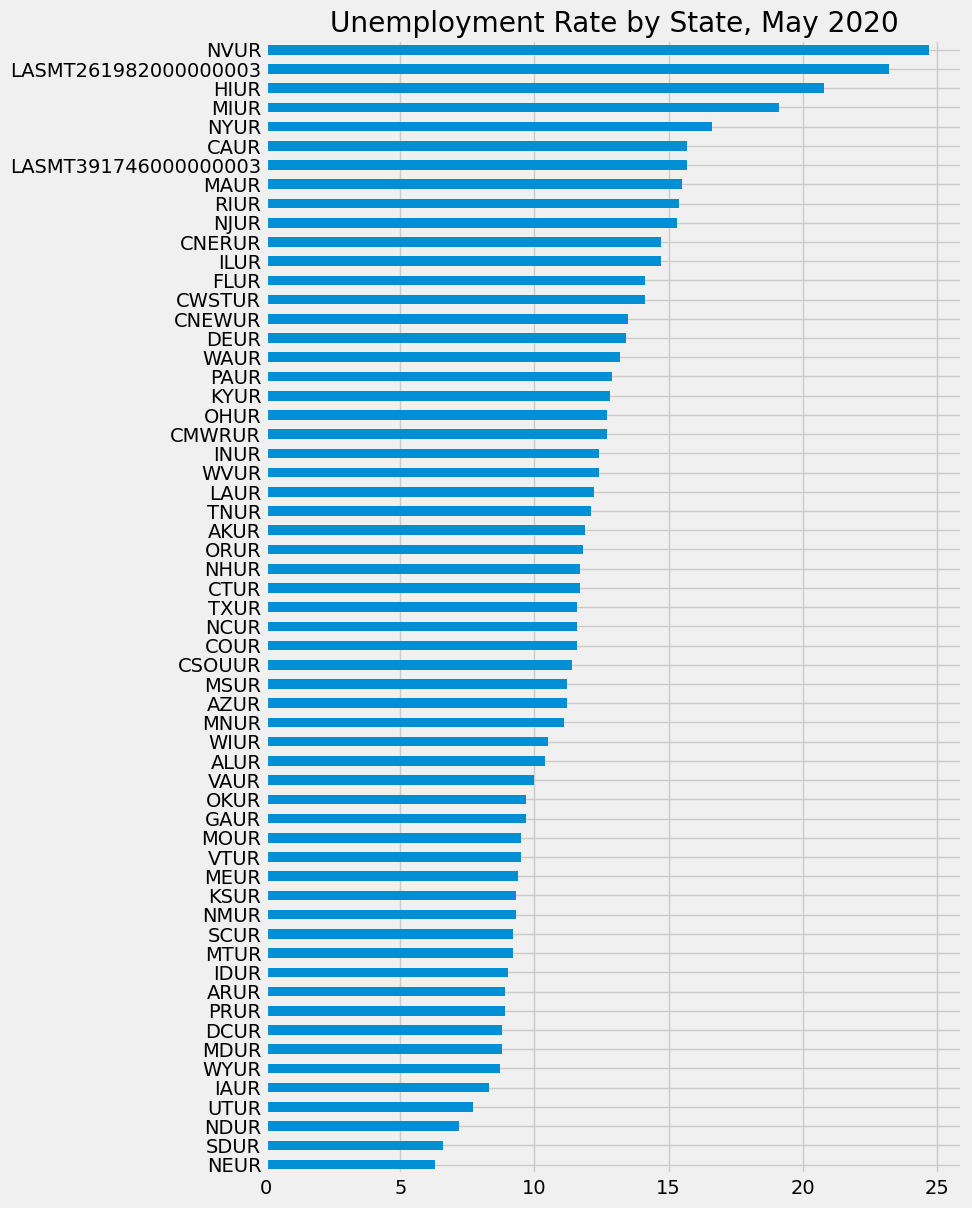

In [149]:
#Plotting an arbitrary date for all states
unem_states.loc[ unem_states.index == '2020-05-01' ].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8,14), title='Unemployment Rate by State, May 2020')
plt.legend().remove()

In [150]:
# Create a dictionary to match the code of each state to its actual name
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in', '').to_dict()

In [151]:
# Replace the id to the actual states names
unem_states.columns = [id_to_state[i] for i in unem_states.columns]

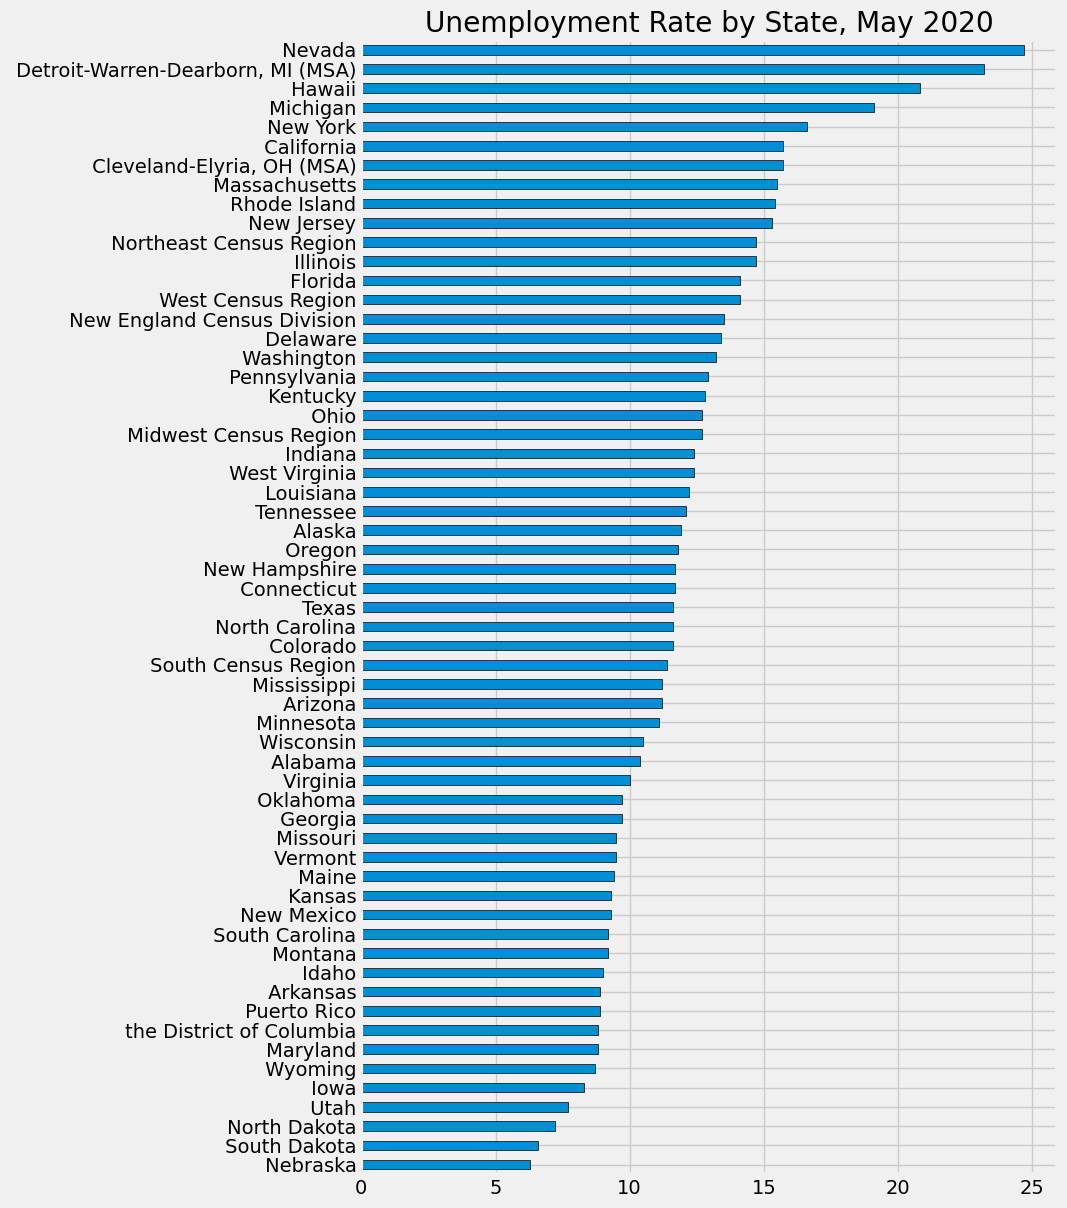

In [152]:
# make again the bar plot now with the names of the states
unem_states.loc[ unem_states.index == '2020-05-01' ].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8,14), title='Unemployment Rate by State, May 2020', edgecolor='black')
plt.legend().remove()

In [153]:
# The interactive plot again but with the names of the states
px.line(unem_states)

# Pulling Data of Labor Force Participation Rate

<b> Now we make a similar procces, but much cleaner </b>

In [154]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('units == "Percent" and seasonal_adjustment == "Seasonally Adjusted" ')
# We clean the data so we have only data per state
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for')]
part_df.shape

(51, 15)

<b> We got almost got the same number of states as for the unemployment data, so all good </b>

In [155]:
id_part_to_state = part_df['title'].str.replace('Labor Force Participation Rate for', '').to_dict()

all_results_part=[]

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results_part.append(results) 

#New dict with all the states
part_results = pd.concat(all_results_part, axis=1)
#rename the columns
part_results.columns = [id_part_to_state[i] for i in part_results.columns]

<Axes: >

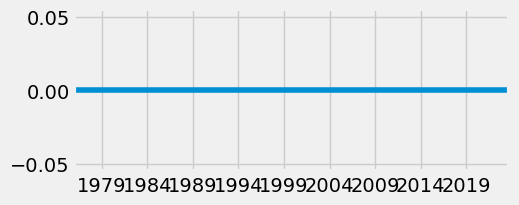

In [156]:
# There is no null values
part_results.isnull().sum(axis=1).plot(figsize=(5,2))

# Plot Unemployment vs Participation

## 1) Validate Both Data Set Have the Same States

In [157]:
id_part_to_state = pd.DataFrame.from_dict(id_part_to_state,orient='index',columns=['name'])
id_to_state = pd.DataFrame.from_dict(id_to_state,orient='index',columns=['name'])

In [192]:
#Inner join to get the common states
unem_vs_part_states_id = pd.merge(id_part_to_state,id_to_state, left_on='name', right_on='name', how='inner')
unem_vs_part_states_id_list = list(unem_vs_part_states_id['name'])
unem_vs_part_states_id_list.shape

(59, 1)

In [203]:
# Extracting only the states that are in both data sets
new_unem_df = unem_states.copy()[unem_vs_part_states_id_list]
new_part_df = part_results.copy()[unem_vs_part_states_id_list]

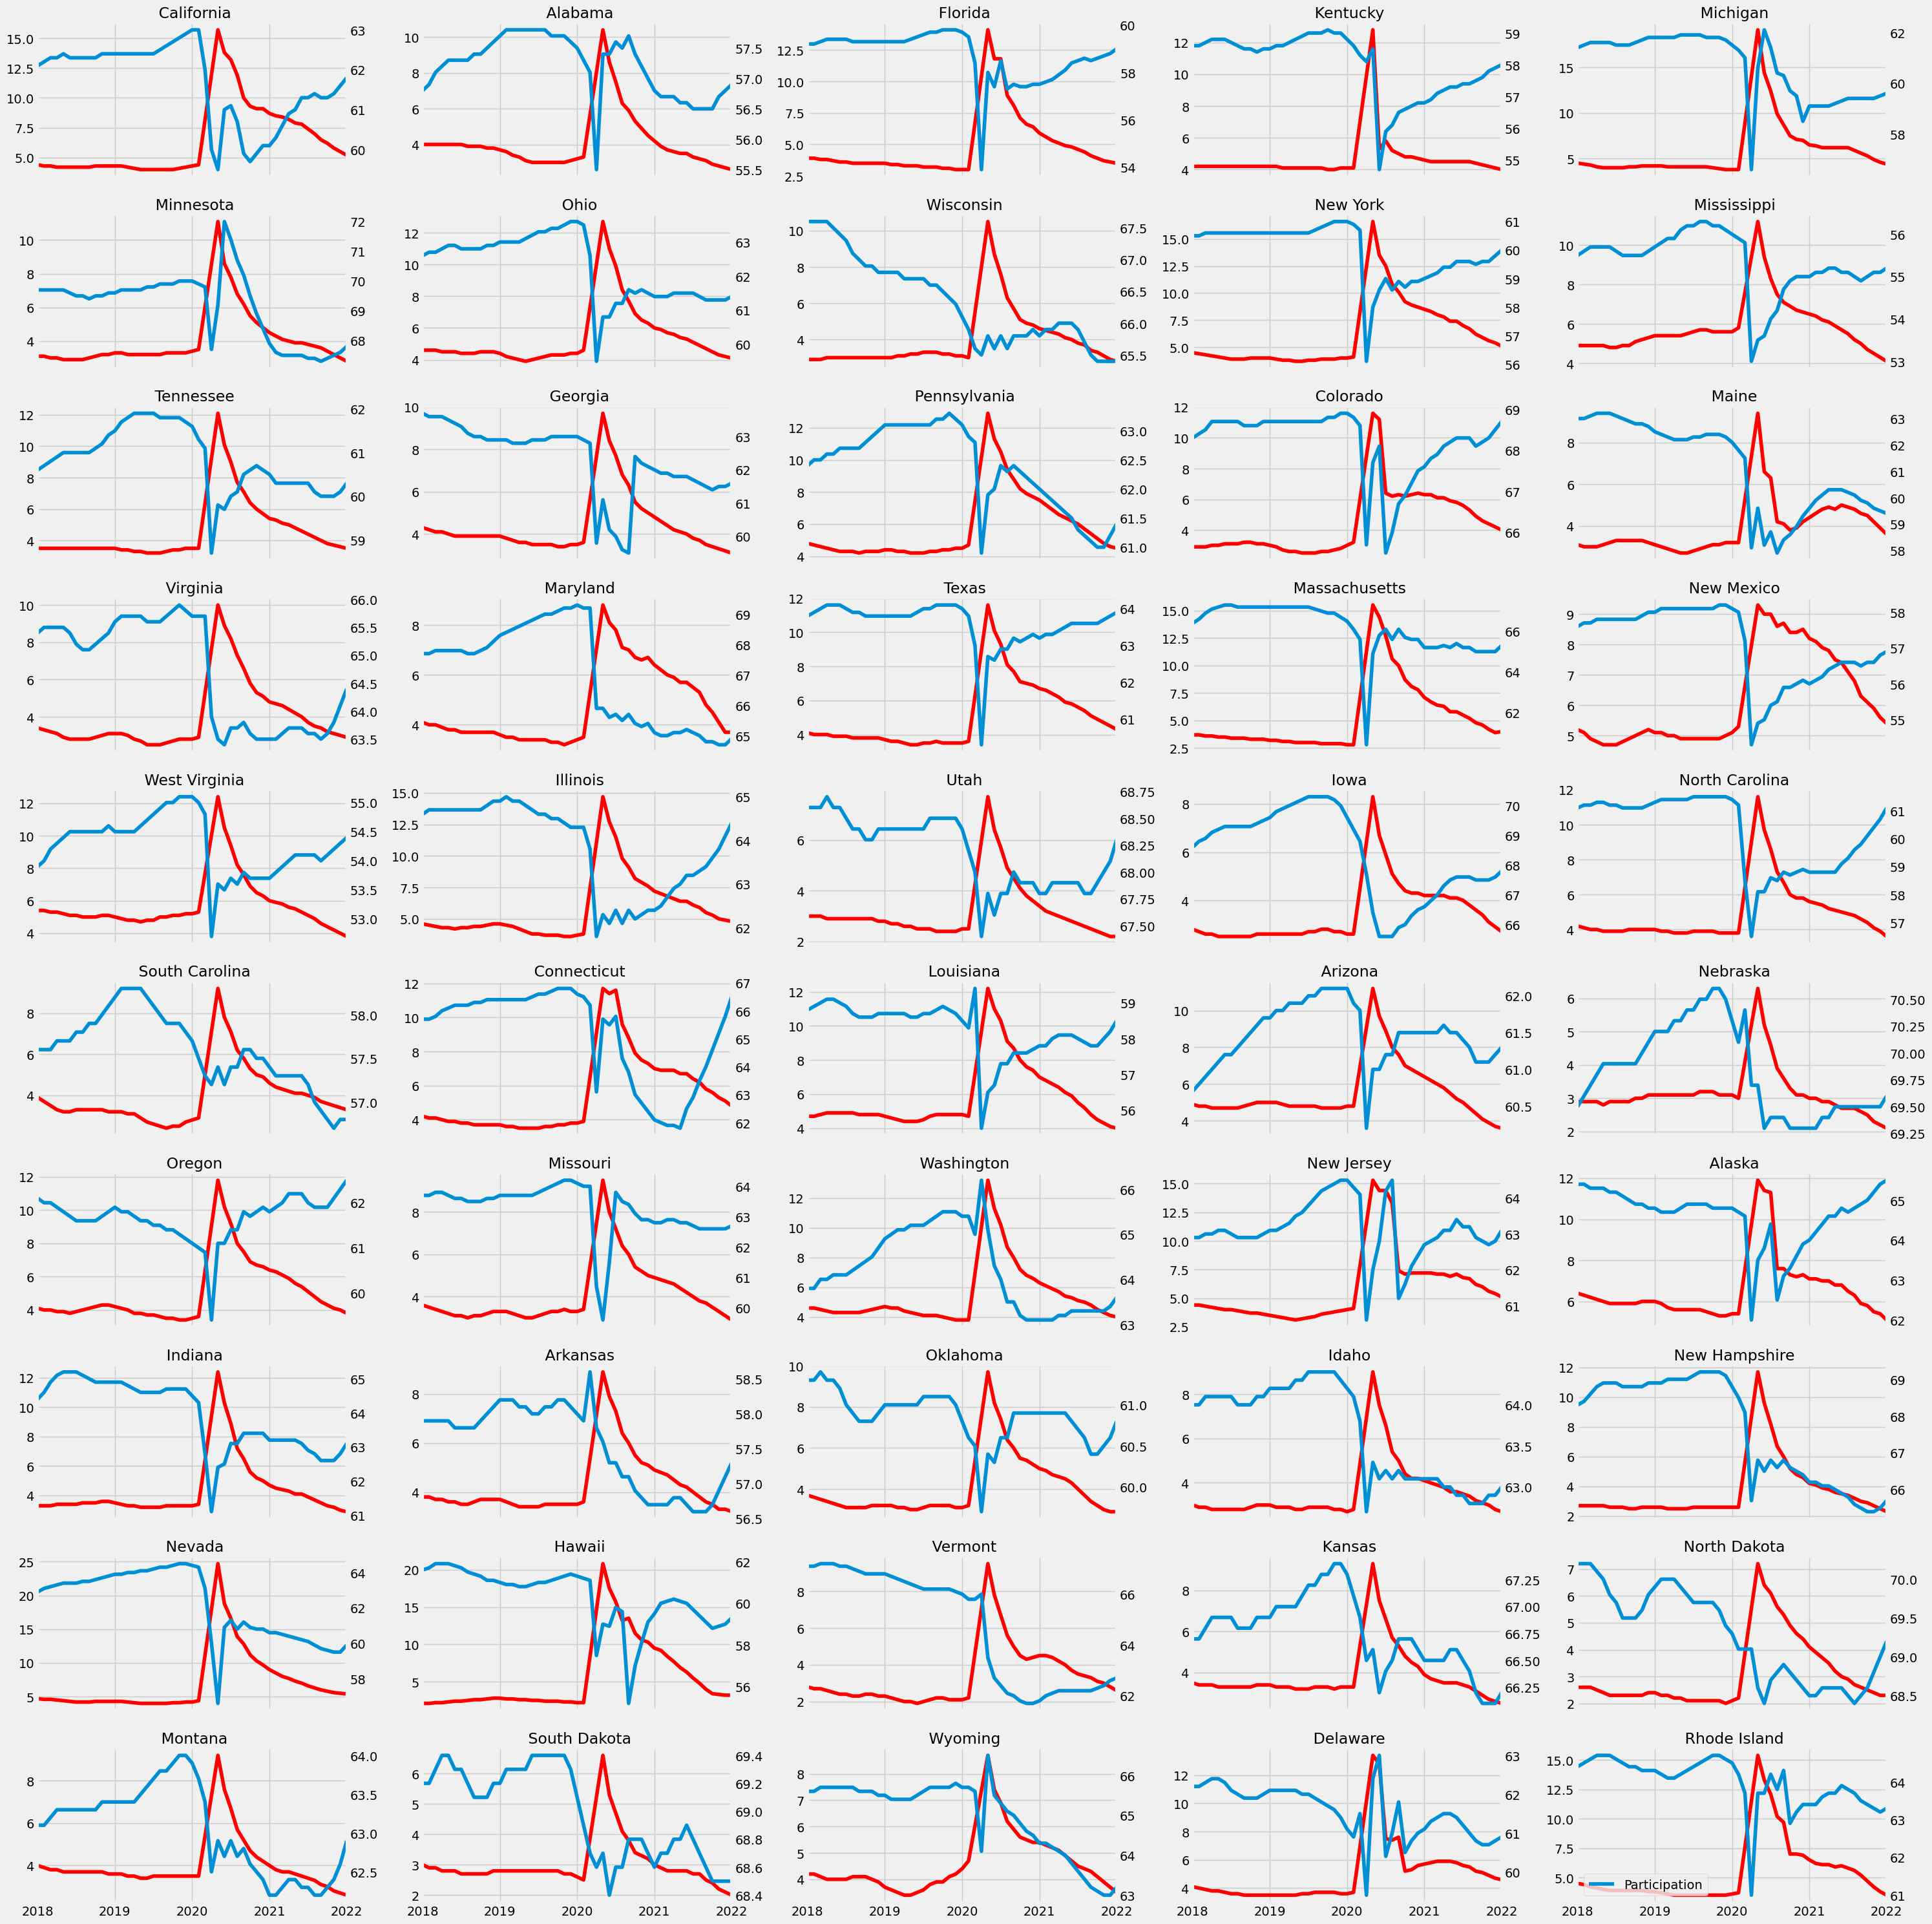

<Figure size 640x480 with 0 Axes>

In [228]:
fig, axs = plt.subplots(10,5, figsize=(30,30), sharex=True)
axs = axs.flatten()


i = 0
for state in unem_vs_part_states_id_list:
    ax2 = axs[i].twinx()
    new_part_df.query(' index >= 2018 and index <= 2022 ')[state]\
        .plot(ax=ax2 , label='Participation')
    new_unem_df.query(' index >= 2018 and index <= 2022 ')[state]\
        .plot(ax=axs[i] , label='Unemployment', color='red')
    axs[i].set_title(state, fontsize=17) 
    plt.grid(False)
    i +=1

plt.tight_layout()
plt.legend( )
plt.show()